# Predict points per minute

## Assumptions
- there is perfect information on which players will play in a game
- there is perfect information on which players will start in a game

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from functools import reduce

In [3]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [137]:
import seaborn as sns

In [4]:
pd.options.display.max_colwidth = 999
pd.options.display.max_rows = 99
pd.options.display.max_columns = 999

In [5]:
%matplotlib inline

%aimport modeling.dataloader
from modeling.dataloader import load_boxscore_data, load_games_data

## Import data tables

In [6]:
from modeling.dataloader import load_boxscore_data, load_game_data, \
    load_season_data, load_team_game_data, load_player_data, load_adv_boxscore_data

In [7]:
# load boxscores
boxscore_data = load_boxscore_data()

/Users/kevinchan/anaconda/envs/nba-analysis/lib/python3.6/site-packages/pyarrow/pandas_compat.py:707: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/Users/kevinchan/anaconda/envs/nba-analysis/lib/python3.6/site-packages/pyarrow/pandas_compat.py:734: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/Users/kevinchan/anaconda/envs/nba-analysis/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [8]:
# load advanced boxscores
adv_boxscore_data = load_adv_boxscore_data()

/Users/kevinchan/anaconda/envs/nba-analysis/lib/python3.6/site-packages/pyarrow/pandas_compat.py:707: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/Users/kevinchan/anaconda/envs/nba-analysis/lib/python3.6/site-packages/pyarrow/pandas_compat.py:734: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/Users/kevinchan/anaconda/envs/nba-analysis/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [9]:
# load games
game_data = load_game_data()

/Users/kevinchan/anaconda/envs/nba-analysis/lib/python3.6/site-packages/pyarrow/pandas_compat.py:707: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/Users/kevinchan/anaconda/envs/nba-analysis/lib/python3.6/site-packages/pyarrow/pandas_compat.py:734: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/Users/kevinchan/anaconda/envs/nba-analysis/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [10]:
# load team games
team_game_data = load_team_game_data()

/Users/kevinchan/anaconda/envs/nba-analysis/lib/python3.6/site-packages/pyarrow/pandas_compat.py:707: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/Users/kevinchan/anaconda/envs/nba-analysis/lib/python3.6/site-packages/pyarrow/pandas_compat.py:734: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/Users/kevinchan/anaconda/envs/nba-analysis/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [11]:
# load seasons
seasons_data = load_season_data()

/Users/kevinchan/anaconda/envs/nba-analysis/lib/python3.6/site-packages/pyarrow/pandas_compat.py:707: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/Users/kevinchan/anaconda/envs/nba-analysis/lib/python3.6/site-packages/pyarrow/pandas_compat.py:734: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/Users/kevinchan/anaconda/envs/nba-analysis/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [12]:
# load players
players_data = load_player_data()

/Users/kevinchan/anaconda/envs/nba-analysis/lib/python3.6/site-packages/pyarrow/pandas_compat.py:707: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/Users/kevinchan/anaconda/envs/nba-analysis/lib/python3.6/site-packages/pyarrow/pandas_compat.py:734: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/Users/kevinchan/anaconda/envs/nba-analysis/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


## Derived data tables

Generate table of all possible games a player could have played in.

Assumption: in the case that a play changes teams, the first game that the player plays for the new team is the first time the player has become available for that team

In [13]:
# get first and last game played by each player for each team, 
# every time the player changes teams
first_game_with_team = (boxscore_data[["player_link", "boxscore_link", "team"]]
    .merge(game_data[["boxscore_link", "date"]], on="boxscore_link")
    .sort_values(by=["player_link", "date"])
    .assign(games_with_team=lambda x: 
                x.groupby(["player_link", "team"])["team"].cumcount())
    .assign(diff_in_count=lambda x: 
                x.groupby(["player_link"])["games_with_team"].diff().fillna(0))
    .query("diff_in_count != 1")
    .assign(team_stint=lambda x:
               x.groupby(["player_link", "team"])["boxscore_link"].cumcount() + 1)
    .rename(columns={"date": "first_game_date"})
    [["player_link", "team", "team_stint", "first_game_date"]]
)

last_game_with_team = (boxscore_data[["player_link", "boxscore_link", "team"]]
    .merge(game_data[["boxscore_link", "date"]], on="boxscore_link")
    .sort_values(by=["player_link", "date"])
    .assign(games_with_team=lambda x: 
                x.groupby(["player_link", "team"])["team"].cumcount())
    .assign(diff_in_count=lambda x: 
                x.groupby(["player_link"])["games_with_team"].diff(-1).fillna(0))
    .query("diff_in_count != -1")
    .assign(team_stint=lambda x:
                x.groupby(["player_link", "team"])["boxscore_link"].cumcount() + 1)
    .rename(columns={"date": "last_game_date"})
    [["player_link", "team", "team_stint", "last_game_date"]]
)

player_teams = first_game_with_team.merge(
    last_game_with_team, on=["player_link", "team", "team_stint"]
)

In [14]:
# join to all games played by every team
# remove games that are before first game played in each stint
player_games_data = (
    player_teams
    .merge(team_game_data[["boxscore_link", "team"]], on="team")
    .merge(game_data[["boxscore_link", "date"]], on="boxscore_link")
    .query("date >= first_game_date and date <= last_game_date")
)

## Sort tables

In [15]:
# sort tables along their indices
boxscore_data = boxscore_data.sort_values(by=["boxscore_link", "player_link"])
game_data = game_data.sort_values(by=["boxscore_link"])
team_game_data = team_game_data.sort_values(by=["boxscore_link", "team_link"])
seasons_data = seasons_data.sort_values(by=["season_link"])
players_data = players_data.sort_values(by=["player_link"])
player_games_data = player_games_data.sort_values(by=["boxscore_link", "player_link"])

## Pre-feature generation filters

In [16]:
# filter playoff games
regular_season_games = game_data["boxscore_link"][game_data["playoffs"] == False]

In [17]:
# filter last 5 games of season
games_before_end_of_season = (
    game_data
        .merge(team_game_data, how="left", on="boxscore_link")
        .assign(game_left_in_season=lambda x: 
            x.groupby(['team_link', 'season_link', 'playoffs'])['date']
             .rank(method='dense', ascending=False)
        )
        .query("game_left_in_season > 5")
)

In [18]:
# filter games before year 2000
games_after_2000 = (
    game_data
        .merge(seasons_data, how="left", on="season_link")
        .query("season >= 2000")
        .eval("boxscore_link")
)

In [19]:
filtered_boxscore_data = boxscore_data[
    boxscore_data["boxscore_link"].isin(regular_season_games)
    & boxscore_data["boxscore_link"].isin(games_after_2000)
    & boxscore_data["minutes"].fillna(0).gt(0)
]

In [20]:
filtered_adv_boxscore_data = adv_boxscore_data[
    adv_boxscore_data["boxscore_link"].isin(regular_season_games)
    & adv_boxscore_data["boxscore_link"].isin(games_after_2000)
    & adv_boxscore_data["minutes"].fillna(0).gt(0)
]

In [21]:
filtered_player_games = player_games_data[
    player_games_data["boxscore_link"].isin(regular_season_games)
    & player_games_data["boxscore_link"].isin(games_after_2000)
]

## Generate derived features

In [22]:
from modeling.transformations import RollingAverageStats, PerUnitStats, \
    Merge, SeasonGameCount, PlayerAge, GameCount

In [23]:
# per minute stats
boxscore_stats = [
    'ast', 'blk', 'drb', 'fg', 'fg3', 'fg3a',
    'fga', 'ft', 'fta', 'orb', 'pf', 'plus_minus', 
    'pts', 'stl', 'tov', 'trb'
]

adv_stats = [
    'ast_pct', 'blk_pct', 'def_rtg', 'drb_pct', 'efg_pct',
    'fg3a_per_fga_pct', 'fta_per_fga_pct', 'off_rtg', 'orb_pct', 'stl_pct', 
    'tov_pct', 'trb_pct', 'ts_pct', 'usg_pct', 'minutes'
]

naming_func = lambda x: f"{x}_per_min"
per_min_stats = list(map(naming_func, boxscore_stats))
per_min_boxscore_data = PerUnitStats(
    stats=boxscore_stats,
    dividend="minutes",
    naming_func=naming_func
).transform(filtered_boxscore_data)

In [24]:
# average score in last n games played
# rolling average of stat, sorted by date, grouped by player
# 5 games
avg_5g_stats = RollingAverageStats(
    stats=boxscore_stats,
    window=5
).transform(
    boxscore_data=filtered_boxscore_data, 
    game_data=game_data
)

avg_5g_adv_stats = RollingAverageStats(
    stats=adv_stats,
    window=5
).transform(
    boxscore_data=filtered_adv_boxscore_data, 
    game_data=game_data
)

avg_5g_per_min_stats = RollingAverageStats(
    stats=per_min_stats, 
    window=5
).transform(
    boxscore_data=per_min_boxscore_data, 
    game_data=game_data, 
)

# 30 games
avg_30g_stats = RollingAverageStats(
    stats=boxscore_stats,
    window=30
).transform(
    boxscore_data=filtered_boxscore_data, 
    game_data=game_data
)

avg_30g_adv_stats = RollingAverageStats(
    stats=adv_stats,
    window=30
).transform(
    boxscore_data=filtered_adv_boxscore_data, 
    game_data=game_data
)

avg_30g_per_min_stats = RollingAverageStats(
    stats=per_min_stats, 
    window=30
).transform(
    boxscore_data=per_min_boxscore_data, 
    game_data=game_data, 
)

In [25]:
# difference in stats over time
# 5 days over 30 days
avg_5_minus_30g_stats = (
    avg_5g_stats[["player_link", "boxscore_link"]]
    .join(
        (
            avg_5g_stats[[col for col in avg_5g_stats if col not in ["player_link", "boxscore_link"]]]
            - avg_30g_stats[[col for col in avg_30g_stats if col not in ["player_link", "boxscore_link"]]].values
        ).rename(columns=lambda x: f"{x}_min_30g")
    )
)

# 30 days over 60 days
avg_30_minus_60g_stats = (
    avg_30g_stats[["player_link", "boxscore_link"]]
    .join(
        (
            avg_30g_stats[[col for col in avg_30g_stats if col not in ["player_link", "boxscore_link"]]]
            - avg_60g_stats[[col for col in avg_60g_stats if col not in ["player_link", "boxscore_link"]]].values
        ).rename(columns=lambda x: f"{x}_min_60g")
    )
)

In [26]:
# player's stats ~ player's average stats + change in team's other active players' stats
player_team_game_stats = (
    filtered_boxscore_data[["boxscore_link", "player_link", "team"]]
    .merge(game_data[["boxscore_link", "date"]])
    .sort_values(by=["player_link", "date"])
    .merge(filtered_boxscore_data.rename(columns={"player_link": "teammate_player_link"}))
    .groupby(["boxscore_link", "player_link"])[boxscore_stats].sum()
    .rename(columns=lambda x: f"team_{x}")
    .reset_index()
)

player_avg_team_stats = RollingAverageStats(
    stats=[col for col in player_team_game_stats 
           if col not in ["boxscore_link", "player_link"]],
    window=30
).transform(
    boxscore_data=player_team_game_stats,
    game_data=game_data
)

active_team_avg_30g_stats = (
    filtered_boxscore_data[["boxscore_link", "player_link", "team"]]
    .merge(avg_30g_stats)
    .pipe(lambda x: 
            x[["boxscore_link", "player_link"]]
            .join(
                x.groupby(["boxscore_link", "team"])
                [[col for col in avg_30g_stats if col not in ["player_link", "boxscore_link"]]]
                .transform("sum")
                .rename(columns=lambda x: f"active_team_{x}")
            )
    )
)

In [123]:
# opponent average stat allowed in last n games, by position
opponent_avgs_allowed = (
    filtered_boxscore_data
    .merge(game_data, on=["boxscore_link"])
    .merge(team_game_data[["boxscore_link", "team"]].rename(columns={"team": "opponent"}), on=["boxscore_link"])
    .query("team != opponent")
    .groupby(["boxscore_link", "opponent", "date"])[boxscore_stats].sum()
    .reset_index()
    .sort_values(by=["opponent", "date"])
    .pipe(
        lambda x:
            x[["boxscore_link", "opponent"]].join(
                x.groupby(["opponent"])[boxscore_stats]
                .apply(lambda x: x.shift(1).rolling(window=30, min_periods=1).mean())
                .rename(columns=lambda x: f"{x}_avg_30g_allowed")
            )
    )
    .merge(filtered_boxscore_data[["boxscore_link", "player_link", "team"]])
    .query("team != opponent")
    .drop(columns=["team", "opponent"])
)

In [ ]:
# player opponent allowed stats
(
    filtered_boxscore_data
    .merge(game_data, on=["boxscore_link"])
    .merge(team_game_data[["boxscore_link", "team"]].rename(columns={"team": "opponent"}), on=["boxscore_link"])
    .query("team != opponent")
    .groupby(["boxscore_link", "opponent", "date"])[boxscore_stats].sum()
    .reset_index()
    .sort_values(by=["opponent", "date"])
    .pipe(
        lambda x:
            x[["boxscore_link", "opponent"]].join(
                x.groupby(["opponent"])[boxscore_stats]
                .apply(lambda x: x.shift(1).rolling(window=30, min_periods=1).mean())
                .rename(columns=lambda x: f"{x}_avg_30g_allowed")
            )
    )
    .merge(filtered_boxscore_data[["boxscore_link", "player_link", "team"]])
    .query("team != opponent")
    .drop(columns=["team", "opponent"])
)

In [163]:
filtered_boxscore_data.head()

,ast,blk,boxscore,drb,fg,fg3,fg3_pct,fg3a,fg_pct,fga,ft,ft_pct,fta,boxscore_link,mp,orb,pf,player,player_link,plus_minus,pts,reason,role,stl,team,tov,trb,minutes
407274,1.0,2.0,basic,15.0,5.0,0.0,NaN,0.0,0.714,7.0,4.0,1.000,4.0,https://www.basketball-reference.com/boxscores/200010310ATL.html,38:00,1.0,2.0,P.J. Brown,https://www.basketball-reference.com/players/b/brownpj01.html,28.0,14.0,None,starter,1.0,Charlotte Hornets,1.0,16.0,38.0
407311,0.0,4.0,basic,5.0,3.0,0.0,NaN,0.0,0.429,7.0,7.0,0.778,9.0,https://www.basketball-reference.com/boxscores/200010310ATL.html,31:00,1.0,5.0,Elden Campbell,https://www.basketball-reference.com/players/c/campbel01.html,21.0,13.0,None,starter,1.0,Charlotte Hornets,4.0,6.0,31.0
407463,3.0,0.0,basic,1.0,1.0,0.0,NaN,0.0,0.125,8.0,4.0,1.000,4.0,https://www.basketball-reference.com/boxscores/200010310ATL.html,21:00,0.0,4.0,Chris Crawford,https://www.basketball-reference.com/players/c/crawfch01.html,-31.0,6.0,None,reserve,0.0,Atlanta Hawks,1.0,1.0,21.0
407289,3.0,0.0,basic,5.0,7.0,2.0,1.0,2.0,0.636,11.0,4.0,0.571,7.0,https://www.basketball-reference.com/boxscores/200010310ATL.html,36:00,1.0,3.0,Baron Davis,https://www.basketball-reference.com/players/d/davisba01.html,14.0,20.0,None,starter,2.0,Charlotte Hornets,5.0,6.0,36.0
407335,0.0,0.0,basic,1.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,https://www.basketball-reference.com/boxscores/200010310ATL.html,6:00,0.0,0.0,Hersey Hawkins,https://www.basketball-reference.com/players/h/hawkihe01.html,-2.0,0.0,None,reserve,0.0,Charlotte Hornets,0.0,1.0,6.0


In [ ]:
# count of bench games
(
    filtered_boxscore_data
    .merge(game_data, on=["boxscore_link"])
    .merge(team_game_data[["boxscore_link", "team"]].rename(columns={"team": "opponent"}), on=["boxscore_link"])
    .query("team != opponent")
    .groupby(["boxscore_link", "opponent", "date"])[boxscore_stats].sum()
    .reset_index()
    .sort_values(by=["opponent", "date"])
    .pipe(
        lambda x:
            x[["boxscore_link", "opponent"]].join(
                x.groupby(["opponent"])[boxscore_stats]
                .apply(lambda x: x.shift(1).rolling(window=30, min_periods=1).mean())
                .rename(columns=lambda x: f"{x}_avg_30g_allowed")
            )
    )
    .merge(filtered_boxscore_data[["boxscore_link", "player_link", "team"]])
    .query("team != opponent")
    .drop(columns=["team", "opponent"])
)

In [27]:
# opponent active players' average stats allowed in last n games, by position

In [27]:
# time between games

In [28]:
# number of games missed
    # cumulative count of games played by player's team up to date
    # cumulative count of games played by player up to date
    # difference between

In [29]:
# merge team-game attributes
team_game_attributes = Merge(
    on=["team", "boxscore_link"],
    how="left",
    keep=["player_link", "boxscore_link", "location"]
).transform(
    left=filtered_boxscore_data,
    right=team_game_data
).pipe( # encode location var
    lambda x: x.join(pd.get_dummies(x["location"], prefix="location", drop_first=True))
).drop(
    columns=["location"]
)

In [30]:
# merge player attributes
player_game_attributes = Merge(
    on=["player_link"],
    how="left",
    keep=["player_link", "boxscore_link", "height", 
          "weight", "year_min", "pos_f", "pos_c", "pos_g", 
          "n_pos", "pos_f_scaled", "pos_c_scaled", "pos_g_scaled"]
).transform(
    left=filtered_boxscore_data,
    right=players_data
)

In [31]:
# count number of games played in season
game_count = (
    GameCount()
    .transform(
        boxscore_data=filtered_boxscore_data,
        game_data=game_data
    )
)

In [32]:
# count number of games played in season
season_game_count = (
    SeasonGameCount()
    .transform(
        boxscore_data=filtered_boxscore_data,
        game_data=game_data
    )
)

In [33]:
# player age
player_age = (
    PlayerAge()
    .transform(
        boxscore_data=filtered_boxscore_data,
        game_data=game_data,
        player_data=players_data
    )
)

## Consolidate predictors and target variable

In [34]:
target_data = filtered_boxscore_data[["boxscore_link", "player_link", "pts"]]

In [146]:
feature_data = reduce(
    lambda left, right: pd.merge(left, right, how="outer", on=["boxscore_link", "player_link"]),
    [
        avg_5g_stats, avg_5g_per_min_stats, avg_5g_adv_stats, 
        avg_30g_stats, avg_30g_per_min_stats, avg_30g_adv_stats, 
        season_game_count, player_game_attributes, team_game_attributes,
        player_age, avg_5_minus_30g_stats, game_count, 
        active_team_avg_30g_stats, player_avg_team_stats, opponent_avgs_allowed
    ]
)
feature_data = (
    feature_data
    .eval("chng_active_team_pts_30g_avg = active_team_pts_prev_30g_avg - team_pts_prev_30g_avg")
    .eval("diff_avg_30g_opp_pts_allowed = pts_avg_30g_allowed - team_pts_prev_30g_avg")
)

In [147]:
combined_data = target_data.merge(feature_data, how='left', on=["boxscore_link", "player_link"])

In [148]:
len(combined_data), len(target_data)

(446531, 446531)

## Post transformation filters

In [149]:
filtered_combined_data = combined_data.query("game_count > 30")

## Missing value treatment

In [150]:
# which columns have missing values
columns_with_missing_values = (
    filtered_combined_data.columns[filtered_combined_data.isna().any(axis=0)]
)
columns_with_missing_values

Index(['efg_pct_prev_5g_avg', 'fg3a_per_fga_pct_prev_5g_avg',
       'fta_per_fga_pct_prev_5g_avg', 'tov_pct_prev_5g_avg',
       'ts_pct_prev_5g_avg', 'ast_avg_30g_allowed', 'blk_avg_30g_allowed',
       'drb_avg_30g_allowed', 'fg_avg_30g_allowed', 'fg3_avg_30g_allowed',
       'fg3a_avg_30g_allowed', 'fga_avg_30g_allowed', 'ft_avg_30g_allowed',
       'fta_avg_30g_allowed', 'orb_avg_30g_allowed', 'pf_avg_30g_allowed',
       'plus_minus_avg_30g_allowed', 'pts_avg_30g_allowed',
       'stl_avg_30g_allowed', 'tov_avg_30g_allowed', 'trb_avg_30g_allowed',
       'diff_avg_30g_opp_pts_allowed'],
      dtype='object')

In [151]:
# how many values are missing
filtered_combined_data[columns_with_missing_values].isna().sum()

efg_pct_prev_5g_avg             255
fg3a_per_fga_pct_prev_5g_avg    255
fta_per_fga_pct_prev_5g_avg     255
tov_pct_prev_5g_avg              87
ts_pct_prev_5g_avg              141
ast_avg_30g_allowed              68
blk_avg_30g_allowed              68
drb_avg_30g_allowed              68
fg_avg_30g_allowed               68
fg3_avg_30g_allowed              68
fg3a_avg_30g_allowed             68
fga_avg_30g_allowed              68
ft_avg_30g_allowed               68
fta_avg_30g_allowed              68
orb_avg_30g_allowed              68
pf_avg_30g_allowed               68
plus_minus_avg_30g_allowed       68
pts_avg_30g_allowed              68
stl_avg_30g_allowed              68
tov_avg_30g_allowed              68
trb_avg_30g_allowed              68
diff_avg_30g_opp_pts_allowed     68
dtype: int64

In [152]:
# drop records with missing values: very small proportion of records
clean_data = filtered_combined_data.dropna()

## Split training and validation dataset

## Split into Validation and Training data

## Train model

In [135]:
list(filter(lambda x: "allowed" in x, clean_data.columns))

['ast_avg_30g_allowed',
 'blk_avg_30g_allowed',
 'drb_avg_30g_allowed',
 'fg_avg_30g_allowed',
 'fg3_avg_30g_allowed',
 'fg3a_avg_30g_allowed',
 'fga_avg_30g_allowed',
 'ft_avg_30g_allowed',
 'fta_avg_30g_allowed',
 'orb_avg_30g_allowed',
 'pf_avg_30g_allowed',
 'plus_minus_avg_30g_allowed',
 'pts_avg_30g_allowed',
 'stl_avg_30g_allowed',
 'tov_avg_30g_allowed',
 'trb_avg_30g_allowed']

### Candidate 0: Previous 30 game average

In [157]:
ols("pts ~ pts_prev_30g_avg - 1", data=clean_data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    pts   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                 1.594e+06
Date:                Mon, 28 Jan 2019   Prob (F-statistic):               0.00
Time:                        00:09:30   Log-Likelihood:            -1.2719e+06
No. Observations:              400456   AIC:                         2.544e+06
Df Residuals:                  400455   BIC:                         2.544e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
pts_prev_30g_avg     0.9858      0.001   1262.372      0.000       0.984       0.987
==============================================================================
Omnibus:                    25411.606   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            38761.634
Skew:                           0.532   Prob(JB):                         0.00
Kurtosis:                       4.092   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Candidate 1: Linear regression ~ previous average

In [99]:
ols("pts ~ pts_prev_30g_avg", data=clean_data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    pts   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                 3.808e+05
Date:                Sun, 27 Jan 2019   Prob (F-statistic):               0.00
Time:                        20:44:11   Log-Likelihood:            -1.2718e+06
No. Observations:              400524   AIC:                         2.544e+06
Df Residuals:                  400522   BIC:                         2.544e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.4775      0.018     26.425      0.000       0.442       0.513
pts_prev_30g_avg     0.9507      0.002    617.108      0.000       0.948       0.954
==============================================================================
Omnibus:                    28091.532   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            42334.748
Skew:                           0.578   Prob(JB):                         0.00
Kurtosis:                       4.096   Cond. No.                         23.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Candidate 2: Linear regression ~ previous average + change in stat

In [100]:
ols("pts ~ pts_prev_30g_avg + pts_prev_5g_avg_min_30g", 
    data=clean_data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    pts   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                 2.032e+05
Date:                Sun, 27 Jan 2019   Prob (F-statistic):               0.00
Time:                        20:44:13   Log-Likelihood:            -1.2653e+06
No. Observations:              400524   AIC:                         2.531e+06
Df Residuals:                  400521   BIC:                         2.531e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.4458      0.018     25.069      0.000       0.411       0.481
pts_prev_30g_avg            0.9542      0.002    629.320      0.000       0.951       0.957
pts_prev_5g_avg_min_30g     0.3711      0.003    114.383      0.000       0.365       0.377
==============================================================================
Omnibus:                    28127.109   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            43930.328
Skew:                           0.566   Prob(JB):                         0.00
Kurtosis:                       4.163   Cond. No.                         23.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Candidate 3: Linear regression ~ previous average + recent change in stats + difference in active team stats

In [101]:
(
    ols(
        formula="pts ~ pts_prev_30g_avg"
            " + pts_prev_5g_avg_min_30g"
            " + chng_active_team_pts_30g_avg", 
        data=clean_data
    )
    .fit()
    .summary()
)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    pts   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                 1.434e+05
Date:                Sun, 27 Jan 2019   Prob (F-statistic):               0.00
Time:                        20:44:20   Log-Likelihood:            -1.2595e+06
No. Observations:              400524   AIC:                         2.519e+06
Df Residuals:                  400520   BIC:                         2.519e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.3578      0.018     20.392      0.000       0.323       0.392
pts_prev_30g_avg                 0.9688      0.002    645.746      0.000       0.966       0.972
pts_prev_5g_avg_min_30g          0.3073      0.003     94.552      0.000       0.301       0.314
chng_active_team_pts_30g_avg    -0.0795      0.001   -108.914      0.000      -0.081      -0.078
==============================================================================
Omnibus:                    25975.761   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            40319.357
Skew:                           0.535   Prob(JB):                         0.00
Kurtosis:                       4.128   Cond. No.                         25.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Candidate 4: Linear regression ~ previous average + recent change in stats + difference in active team stats + location

In [144]:
(
    ols(
        formula="pts ~ pts_prev_30g_avg"
            " + pts_prev_5g_avg_min_30g"
            " + chng_active_team_pts_30g_avg"
            " + location_home:pts_prev_30g_avg",
        data=clean_data
    )
    .fit()
    .summary()
)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    pts   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                 1.077e+05
Date:                Sun, 27 Jan 2019   Prob (F-statistic):               0.00
Time:                        23:41:04   Log-Likelihood:            -1.2591e+06
No. Observations:              400456   AIC:                         2.518e+06
Df Residuals:                  400451   BIC:                         2.518e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          0.3588      0.018     20.456      0.000       0.324       0.393
pts_prev_30g_avg                   0.9540      0.002    567.147      0.000       0.951       0.957
pts_prev_5g_avg_min_30g            0.3074      0.003     94.606      0.000       0.301       0.314
chng_active_team_pts_30g_avg      -0.0797      0.001   -109.187      0.000      -0.081      -0.078
location_home:pts_prev_30g_avg     0.0295      0.002     19.477      0.000       0.026       0.032
==============================================================================
Omnibus:                    25991.217   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            40324.990
Skew:                           0.535   Prob(JB):                         0.00
Kurtosis:                       4.127   Cond. No.                         27.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Candidate 5: Linear regression ~ previous average + recent change in stats + difference in active team stats + location + above average opponent points allowed

In [161]:
(
    ols(
        formula="pts ~ pts_prev_30g_avg"
            " + pts_prev_5g_avg_min_30g"
            " + chng_active_team_pts_30g_avg"
            " + location_home:pts_prev_30g_avg"
            " + diff_avg_30g_opp_pts_allowed + 1",
        data=clean_data
    )
    .fit()
    .summary()
)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    pts   R-squared:                       0.520
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                 8.666e+04
Date:                Mon, 28 Jan 2019   Prob (F-statistic):               0.00
Time:                        00:12:01   Log-Likelihood:            -1.2585e+06
No. Observations:              400456   AIC:                         2.517e+06
Df Residuals:                  400450   BIC:                         2.517e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          0.3149      0.018     17.930      0.000       0.280       0.349
pts_prev_30g_avg                   0.9585      0.002    568.848      0.000       0.955       0.962
pts_prev_5g_avg_min_30g            0.3080      0.003     94.934      0.000       0.302       0.314
chng_active_team_pts_30g_avg      -0.0804      0.001   -110.204      0.000      -0.082      -0.079
location_home:pts_prev_30g_avg     0.0294      0.002     19.433      0.000       0.026       0.032
diff_avg_30g_opp_pts_allowed       0.0470      0.001     33.795      0.000       0.044       0.050
==============================================================================
Omnibus:                    25773.902   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            40019.176
Skew:                           0.532   Prob(JB):                         0.00
Kurtosis:                       4.126   Cond. No.                         27.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Diagnoistics

In [153]:
predictors = ["pts_prev_30g_avg", "pts_prev_5g_avg_min_30g", "chng_active_team_pts_30g_avg",
              "location_home", "diff_avg_30g_opp_pts_allowed"]
clean_data[predictors].corr()

,pts_prev_30g_avg,pts_prev_5g_avg_min_30g,chng_active_team_pts_30g_avg,location_home,diff_avg_30g_opp_pts_allowed
pts_prev_30g_avg,1.000000,-0.020472,0.091547,0.004186,-0.085403
pts_prev_5g_avg_min_30g,-0.020472,1.000000,-0.181205,-0.000714,-0.008963
chng_active_team_pts_30g_avg,0.091547,-0.181205,1.000000,0.020436,0.020137
location_home,0.004186,-0.000714,0.020436,1.000000,0.002905
diff_avg_30g_opp_pts_allowed,-0.085403,-0.008963,0.020137,0.002905,1.000000


In [155]:
model = (
    ols(
        formula="pts ~ pts_prev_30g_avg"
            " + pts_prev_5g_avg_min_30g"
            " + chng_active_team_pts_30g_avg"
            " + location_home:pts_prev_30g_avg"
            " + diff_avg_30g_opp_pts_allowed",
        data=clean_data
    )
    .fit()
)

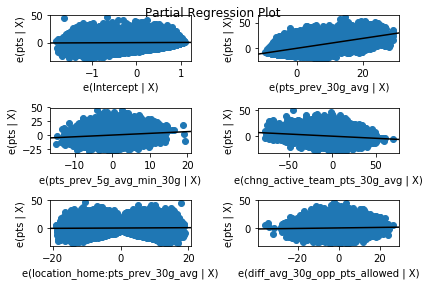

In [156]:
sm.graphics.plot_partregress_grid(model);